# Demo: Landsat and Dynamic Data Access
UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Introduction
* Hopefully you've all seen or used Landsat imagery at some point in the past
* Take a few minutes to refresh your memory: https://www.usgs.gov/land-resources/nli/landsat
* There is a huge amount of information out there on the Landsat missions, data products, science results
* USGS and NASA partnership

## Landsat-8
* Landsat-8 is the mission (a satellite)
    * Operational Land Imager (OLI) is an instrument (a camera)
    * Thermal Infrared Sensor (TIRS) is an insitrument (also a camera, but measures thermal infrared radiation, surface temperature)

Take a look at useful info here: 
* https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-overview
* https://www.usgs.gov/land-resources/nli/landsat/landsat-8

### Orbit and Data collection
Landsat 8 orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi), inclined at 98.2 degrees, and completes one Earth orbit every 99 minutes.  The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.  

Landsat 8 aquires about 740 scenes a day on the Worldwide Reference System-2 (WRS-2) path/row system, with a swath overlap (or sidelap) varying from 7 percent at the equator to a maximum of approximately 85 percent at extreme latitudes. A Landsat 8 scene size is 185 km x 180 km (114 mi x 112 mi). 

### Instruments and Bands 
* https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites

So, Landsat-8 sensor is the top row of colored bands in the following figure (lower rows are for older Landsat sensors):

![LS8 bands](https://landsat.usgs.gov/sites/default/files/images/MSS-thru-L9-wavelengths.jpg)

For comparison with previous Landsat missions: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products

### Dynamic Range
* LS8 OLI provides 12-bit dynamic range, which improves signal to noise ratio.
    * Remember, each bit is a 0 or 1.  We have 12 of them, so we have 2^12 (or 4096) unique combinations to represent brightness in the image.
* Most data types on a computer are in multiples of bytes, which have 8 bits. For example, a typical RGB image of a cat face contains three 8-bit channels for red, green and blue values. 
* LS8 offers a considerable improvement over for the 8-bit dynamic range of Landsat 1-7. Improved signal to noise performance enables improved characterization of land cover state and condition.
* We don't have a convenient mechanism to store 12-bit data, so the LS8 images are stored as 16-bit unsigned integers (2^16 possible values, 0-65535)
    * The initial values (spanning 0-4095) are scaled across 55000 of the total 65535 brightness levels in the 16-bit images

### Image Resolution - Ground Sample Distance (GSD)
* Panchromatic (PAN) band (band number 8) has 15 m ground sample distance (GSD)
* Multispectral (MS) bands are 30 m GSD
* Thermal IR are 100 m GSD, but are often oversampled to match MS bands

## Landsat-8 Data Products
The standard data products are "Level 1" images: they radiometrically corrected and orthorectified (terrain corrected) in the approprate UTM projection: https://www.usgs.gov/core-science-systems/nli/landsat/landsat-level-1-processing-details

For more sophisticated analysis, you typically want to use higher-level, calibrated/corrected products ("level 2" like surface reflectance values), often considered "Analysis Ready Data (ARD)": https://www.usgs.gov/land-resources/nli/landsat/landsat-science-products

Information about Digital Number (DN), top of atmosphere (TOA) and surface reflectance (SR): https://www.l3harrisgeospatial.com/Learn/Blogs/Blog-Details/ArtMID/10198/ArticleID/16278/Digital-Number-Radiance-and-Reflectance
* Top of Atmosphere reflectance
    * Formulas for conversion of DN to TOA: https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
* "Surface reflectance is the amount of light reflected by the surface of the Earth. It is a ratio of surface radiance to surface irradiance, and as such is unitless, with values between 0 and 1."
    * "Surface reflectance (SR) improves comparison between multiple images over the same region by accounting for atmospheric effects such as aerosol scattering and thin clouds, which can help in the detection and characterization of Earth surface change. "
    * "Landsat 8 OLI Collection 1 Surface Reflectance are generated using the Land Surface Reflectance Code (LaSRC) (version 1.4.1), which makes use of the coastal aerosol band to perform aerosol inversion tests, uses auxiliary climate data from MODIS, and uses a unique radiative transfer model.  (Vermote et al., 2016)."

### Path/Row system
* https://landsat.gsfc.nasa.gov/the-worldwide-reference-system/
* Use descending for daytime imagery
* Seattle and Mt. Rainier: path 46, row 27

### LS8 Data availability
USGS/NASA hosts the official Landsat products. This option is great for one-off interactive data searches, but can be clunky and requires a lot of manual steps:
* https://earthexplorer.usgs.gov/

Commercial cloud providers now mirror the entire USGS archive, and provide a much more efficient API (application programming interface) to access the data.  This is especially important when you need to access 100s-1000s of images.

Google:
* https://cloud.google.com/storage/docs/public-datasets/landsat

Amazon Web Services (AWS): 
* https://docs.opendata.aws/landsat-pds/readme.html
* https://registry.opendata.aws/landsat-8/

Microsoft Planetary Computer:
* https://planetarycomputer.microsoft.com/dataset/group/landsat

## Finding cloud-free imagery
The process of identifying and downloading data has evolved considerably throughout the Landsat missions, and modern approaches use on-demand access to cloud-hosted archives, often without local downloads.
* Interactive, manual approach: use EarthExplorer for visual queries: https://earthexplorer.usgs.gov/
    * Get the image ID
    * Can also directly download products from EarthExplorer, but pretty inefficient
* Automated, programmatic approach: query archives from Python API or command-line, using SpatioTemporal Asset Catalog (STAC): https://landsat.stac.cloud
* Other approaches: https://www.usgs.gov/landsat-missions/landsat-data-access
* For now, let's use some code to download some pre-identified images for WA state to the hub.  Note that we could do all of this on the fly, but for experimentation and development, having a local copy of sample images will speed up reading.

In [ ]:
import os
import urllib
import rasterio as rio
import rasterio.plot
import requests

## Note that we can open an image directly from a url
(look Ma, no downloads!)  
Let's use the last url from our earlier download as a test

In [ ]:
image_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF'

In [ ]:
print(image_url)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF


In [ ]:
src = rio.open(image_url)

In [ ]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [ ]:
with rio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
#Note that the dataset does not remain open!
src

<closed DatasetReader name='https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF' mode='r'>

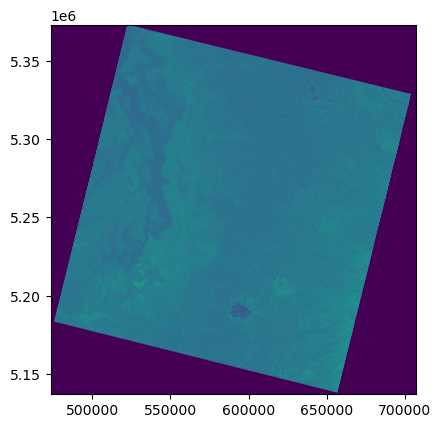

In [ ]:
with rio.open(image_url) as src:
    rio.plot.show(src)

## Download Collection 2 (L2) products for Surface Reflectance and Surface Temperature

In [ ]:
#Create local directory to store images
imgdir = 'LS8_sample'
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

### Download assets for specific images
* Dynamimcally construct url using known information
* Using Microsoft Planetary Computer archive of Collection 2 Level 2 images
    * https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
* Need to obtain token to authenticate ("sign") urls

In [ ]:
#Collection name
collection = 'landsat-8-c2-l2'

In [ ]:
#Base url for this collection
base_url = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs'

In [ ]:
#List of predetermined images (e.g., from STAC, or interactive EarthExplorer or EarthData search)
img_list = ['LC08_L2SP_046027_20180818_20200831_02_T1', \
            'LC08_L2SP_046027_20181224_20200829_02_T1']

In [ ]:
#Subset of assets to download (specific bands for L2 surface reflectance/temperature products)
#Note: no panchromatic (B8) avialable from this collection
asset_id_list = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'reduced_resolution_browse']

Notes on LS filenames: 
* https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes
* https://gisgeography.com/landsat-file-naming-convention/

In [ ]:
# Get a token for signed url preparation
resp = requests.get(f'https://planetarycomputer.microsoft.com/api/sas/v1/token/{collection}')
token = resp.json()['token']

In [ ]:
#Loop through all selected images and all bands
for img in img_list:
    for asset_id in asset_id_list:
        #Generate the appropriate URL for the image IDs
        year = img.split('_')[3][0:4]
        path = img.split('_')[2][0:3]
        row = img.split('_')[2][3:]
        if asset_id == 'reduced_resolution_browse':
            image_url =  f'{base_url}/{year}/{path}/{row}/{img}/{img}_thumb_large.jpeg'
        else:
            image_url =  f'{base_url}/{year}/{path}/{row}/{img}/{img}_{asset_id}.TIF'
            #image_url =  f'{base_url}/{year}/{path:03d}/{row:03d}/{img}/{img}_{asset_id}.TIF'
        print(f'{image_url}?{token}')
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            #signed_asset = pc.sign_asset(pystac.asset.Asset(image_url))
            print("Saving:", out_fn)
            #Download the file
            urllib.request.urlretrieve(f'{image_url}?{token}', out_fn)

## Do a quick `ls -lh` on the local image directory
* Note relative file sizes for the different bands of each image
    * B8 vs B3 vs. B10
    * Revisit the chart above - does this make sense for resolution of these bands?

In [ ]:
!ls -lh $imgdir

total 1.9G
-rw-rw-r-- 1 jovyan users 257M Feb  3 03:57 LC08_L1TP_046027_20180818_20180829_01_T1_B8.TIF
-rw-rw-r-- 1 jovyan users 265M Feb  3 03:57 LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
-rw-rw-r-- 1 jovyan users  81M Feb  1 04:02 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B1.TIF
-rw-rw-r-- 1 jovyan users  81M Feb  1 04:02 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B2.TIF
-rw-rw-r-- 1 jovyan users  82M Feb  1 04:02 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B3.TIF
-rw-rw-r-- 1 jovyan users  83M Feb  1 04:03 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B4.TIF
-rw-rw-r-- 1 jovyan users  92M Feb  1 04:03 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B5.TIF
-rw-rw-r-- 1 jovyan users  90M Feb  1 04:03 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B6.TIF
-rw-rw-r-- 1 jovyan users  86M Feb  1 04:03 LC08_L2SP_046027_20180818_20200831_02_T1_SR_B7.TIF
-rw-rw-r-- 1 jovyan users  84M Feb  1 19:20 LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF
-rw-rw-r-- 1 jovyan users  89K Feb  1 04:04 

## Use `gdalinfo` command to get some basic information about one of the files
* Review output with your neighbor/group
    * 🤔 Talk about what each line means, if there is something you don't understand, ask!  Or look it up together!

In [ ]:
sample_fn = os.path.join(imgdir, img+'_ST_B10.TIF')
print(sample_fn)

LS8_sample/LC08_L2SP_046027_20181224_20200829_02_T1_ST_B10.TIF


In [ ]:
!gdalinfo $sample_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L2SP_046027_20181224_20200829_02_T1_ST_B10.TIF
       LS8_sample/LC08_L2SP_046027_20181224_20200829_02_T1_ST_B10.TIF.aux.xml
Size is 7771, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",

In [ ]:
!gdalinfo $sample_fn -stats

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L2SP_046027_20181224_20200829_02_T1_ST_B10.TIF
       LS8_sample/LC08_L2SP_046027_20181224_20200829_02_T1_ST_B10.TIF.aux.xml
Size is 7771, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",

## Other examples

### Catalog search with STAC
* This should be used when you don't know image IDs up front
* Can search with spatial and temporal limits
* Set cell type as raw for now, since we know Image IDs

In [ ]:
#Install necessary packages
#https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
!mamba install --yes pystac planetary-computer

In [ ]:
# Landsat-8 collection 2 from planetary computer
# https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2#Example-Notebook

import pystac
from pystac_client import Client
import planetary_computer as pc

### Define search parameters

In [ ]:
#Collection
collection = 'landsat-8-c2-l2'

#Bounding box
bbox = [-121.8,46.8,-121.6,46.9]

#Single date
#dt = '2018-08-18'

#Date range
dt = '2018-06-01/2018-12-31'

In [ ]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [ ]:
results = catalog.search(collections=[collection], bbox=bbox, datetime=dt)

# Check how many items were returned
items = list(results.get_items())
print(f"Returned {len(items)} Items")

Returned 52 Items


In [ ]:
#Note: This bbox intersects 4 path/row combinations (046028, 046027, 045028, 045027)
#Could filter STAC search if desired
items

[<Item id=LC08_L2SP_046028_20181224_02_T1>,
 <Item id=LC08_L2SP_046027_20181224_02_T1>,
 <Item id=LC08_L2SP_045028_20181217_02_T1>,
 <Item id=LC08_L2SP_045027_20181217_02_T1>,
 <Item id=LC08_L2SP_046028_20181208_02_T1>,
 <Item id=LC08_L2SP_046027_20181208_02_T1>,
 <Item id=LC08_L2SP_045028_20181201_02_T1>,
 <Item id=LC08_L2SP_045027_20181201_02_T2>,
 <Item id=LC08_L2SP_046028_20181122_02_T2>,
 <Item id=LC08_L2SP_046027_20181122_02_T1>,
 <Item id=LC08_L2SP_045028_20181115_02_T1>,
 <Item id=LC08_L2SP_045027_20181115_02_T1>,
 <Item id=LC08_L2SP_046028_20181106_02_T1>,
 <Item id=LC08_L2SP_046027_20181106_02_T1>,
 <Item id=LC08_L2SP_045028_20181030_02_T1>,
 <Item id=LC08_L2SP_045027_20181030_02_T1>,
 <Item id=LC08_L2SP_046028_20181021_02_T1>,
 <Item id=LC08_L2SP_046027_20181021_02_T1>,
 <Item id=LC08_L2SP_045028_20181014_02_T1>,
 <Item id=LC08_L2SP_045027_20181014_02_T1>,
 <Item id=LC08_L2SP_046028_20181005_02_T2>,
 <Item id=LC08_L2SP_046027_20181005_02_T2>,
 <Item id=LC08_L2SP_045028_20180

In [ ]:
#Notebook has nice formatting for these objects (can also return as dictionary)
items[0]

id: LC08_L2SP_046028_20181224_02_T1
"bbox: [-123.88032007716993, 44.94027505731986, -120.80545247316839, 47.08976494268014]"
datetime: 2018-12-24T18:55:55.723191Z
platform: landsat-8
"proj:bbox: [433185.0, 4978485.0, 666615.0, 5215515.0]"
proj:epsg: 32610
description: Landsat Collection 2 Level-2 Surface Reflectance Product
"instruments: ['oli', 'tirs']"
eo:cloud_cover: 91.62
view:off_nadir: 0
landsat:wrs_row: 028


In [ ]:
#results.get_all_items()

In [ ]:
#Note: this could fill the disk if not careful! Better to open with rioxarray and subset data on the fly

#Download specified assets (bands/products identified in earlier list) for all items

for item in items:
    for asset_id in asset_id_list:
        asset = item.assets[asset_id]
        print(asset.href)
        # NOTE: must 'sign' asset URLs before you can access them
        signed_asset = pc.sign_asset(asset)
        #print(signed_asset.href)
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(asset.href)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
            #Download the file
            #urllib.request.urlretrieve(signed_asset.href, out_fn)

In [ ]:
#Open image on the fly
#with rasterio.open(signed_asset.href) as src:
#    print(src.profile)

### Download Collection 1 Level 1 products (L1TP)
* These include the 15-m Panchromatic band (not available in L2 products)
* Terrain Precision Correction (L1TP) products
    * "Radiometrically calibrated and orthorectified using ground control points (GCPs) and digital elevation model (DEM) data to correct for relief displacement."
    * "scaled and calibrated digital numbers (DN). The DN’s can be scaled to absolutely calibrated radiance or reflectance values using metadata which are distributed with the product. Formulas and information on converting Level-1 data to Top-of-Atmosphere radiance, reflectance, or brightness temperature can be found on the Using the USGS Landsat Level-1 Data Product page."
* See "Landsat Level-1 Processing Levels" https://www.usgs.gov/landsat-missions/landsat-collection-1
* Hosted in Google Cloud with no costs for access: https://cloud.google.com/storage/docs/public-datasets/landsat
    * Transfer rates from Google Cloud should be excellent, as we're running this Jupyterhub on a Google Cloud Platform (GCP) server

In [ ]:
#Use Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

In [ ]:
#Define Landsat path/row for Western Washington
path = 46
row = 27

#Pre-identified cloud-free Image IDs for this path/row 
#Summer 2018
img_id1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

img_list = (img_id2, img_id1)
#img_list = (img_id1,)

In [ ]:
#Loop through all selected images and all bands
for img in img_list:
    path = img.split('_')[2][0:3]
    row = img.split('_')[2][3:]
    #for b in range(1,12):
    for b in [8]:
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1}/{2}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
        print(image_url)
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
            #Download the file
            urllib.request.urlretrieve(image_url, out_fn)